### Course: CSC671-02 
#### Team Number：05
#### Members:
##### Jung Hyun Song 
##### Jeremy Woodling
##### Zicheng Tan 
---

## Some Important Library

In [1]:
import pandas as pd
import string
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.

In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article, "

<Axes: >

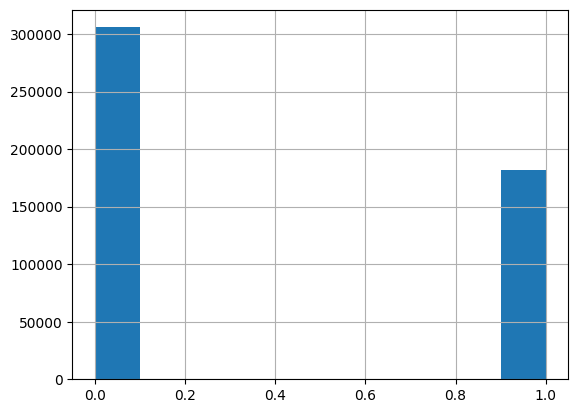

In [2]:
df = pd.read_csv('./AI_Human.csv')
# Print out the first essay for comparison purposes
print(df['text'][0])    
print(df['generated'].value_counts())
df['generated'].hist()

In [3]:
## These Function use to phase the text and padding sequences number from text
## Removing the punctuation and stop words could Improve efficiency of the model and enhance algorithm performance
def remove_punctuation_and_stop_words(text):
    cleaned_text = str.maketrans('', '', string.punctuation)
    text = text.translate(cleaned_text)
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_words = [word for word in word_tokens if word.lower() not in stop_words]  
    filtered_words= ' '.join(filtered_words)
    return filtered_words

## Tranform the text into a sequences number that the model could understand and process=
def pad_sequences_function(text):
    sequences = tokenizer.texts_to_sequences(text)
    output = pad_sequences(sequences, padding='post', maxlen = max_words)
    return output

def format_the_output(results):
    return [1 if output >= 0.5 else 0 for output in results]

def get_the_Accuracy(X,y):
    n= len(X)
    accuracy = (y == X).sum() / n
    return accuracy


In [4]:
#if error shows up because of the nltk package 
# run  " !pip install nltk " 
# this is to get the stopwords, so i could use it to remove them from the original text.

# nltk.download('stopwords')
# nltk.download('punkt')

print(stopwords.words('english'))
df['text']= df['text'].apply(remove_punctuation_and_stop_words)
X = df['text']
y = df['generated']

#get the maxiume number of word in a sentence for 
max_words = max(len(sentence.split()) for sentence in X)
print("The max number of words in the sentence:", max_words)
print(df['text'][0])    


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [5]:

# initial the Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
padded_sequence = pad_sequences_function(X)

#split the data into x_train,x_test,y_train,y_test for model traning purporse and test.
X_train,X_test,y_train,y_test= train_test_split(padded_sequence,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=671,
                                                    stratify= y)
    
print("Training's shape: ", X_train.shape)
          
print("Testing's shape: ", X_test.shape)
   

Training's shape:  (341064, 979)
Testing's shape:  (146171, 979)


In [36]:
from tensorflow.keras.optimizers import Adam
import keras
vocab_size = len(tokenizer.word_index) + 1
print("vocab_size:：", vocab_size)

#this is subclass like pytorch
class LSTMClassification(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim = vocab_size,output_dim = 200)
        self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))
        self.dense_1 = tf.keras.layers.Dense(125, activation='relu')
        # DropoutT layer could prevcent the overfitting issue 
        self.dropout = tf.keras.layers.Dropout(0.4)
        self.dense_2 = tf.keras.layers.Dense(1, activation='sigmoid')
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.lstm(x)
        x = self.dense_1(x)
        x = self.dropout(x)
        x = self.dense_2(x)
        return x 
    
lr = 0.001
loss_function = 'binary_crossentropy'
optimizer = Adam(learning_rate=lr)
model = LSTMClassification()
model.compile(optimizer= optimizer, loss=loss_function, metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
#  prevent overfitting issue, since the dataset is 500k essay. and making a callback object to 
#  monitor the val_loss while traning, if there is no imporvement on the val_loss, the traning will stop,
#  to the best weights, and restore the model .

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=1,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

vocab_size:： 299048


In [37]:
training_info = model.fit(X_train,y_train,epochs= 3,batch_size=256, validation_split=0.3,callbacks=[early_stopping])


Epoch 1/3
933/933 [==============================] - 349s 371ms/step - loss: 0.0466 - accuracy: 0.9841 - val_loss: 0.0500 - val_accuracy: 0.9823
Epoch 2/3
933/933 [==============================] - 434s 465ms/step - loss: 0.0185 - accuracy: 0.9948 - val_loss: 0.0107 - val_accuracy: 0.9973
Epoch 3/3
933/933 [==============================] - 431s 462ms/step - loss: 0.0063 - accuracy: 0.9983 - val_loss: 0.0086 - val_accuracy: 0.9973


In [42]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=64)

2284/2284 [==============================] - 146s 64ms/step - loss: 0.0090 - accuracy: 0.9972


In [43]:
print("The lose of model is : ", test_loss,"The accuracu of model is: ", test_acc)

The lose of model is :  0.008986989967525005 The accuracu of model is:  0.9972224235534668


In [47]:

humen_test = '''
From my perspitive,  the government shouldn’t create a database of all college students to help to track Biden loans. There are many reasons why the government shouldn’t collect our personal information. As a college student, I clearly know how important personal information is. Our personal information represents yourself, it could be used to apply load or apply for some program from an unauthorized company.  There is a  primary reason why the government shouldn’t create a database of all college students. It is our personal privacy. If we actually apply for a Biden loan, Of course, the government could have access to my personal information, but there are some of the college students who didn’t apply for the Biden loan, therefore the government shouldn’t create a database for them to track the Biden loan. Also, based on the general government database, I believe that it stores our personla general information , credit score, SSN, and Identification number.NSA has violated our personal privacy, they spray us through every phone call and the message for so long. Even Though, the potential of this operation is to prevent the terriost attacks, NSA is still violated our personal privacy, which is also influenced the symbol of this country, ”Freedom”. I believe many of us think that America is a free country, It is also one of the main reasons that bring us here in this country. The rule we trust is to protect our privacy, If the goverment create a database for all college student, this I believe it is a violation of our privacy. Maybe subconsciously, this behavior is correct to them, but from what I think, It’s not. We don’t know what kind of information that they will store or record, our privacy is sensitive and protected by the law of this country. On the other hand, If the government created a database of all college students, the government is also involved with our college students. They did that without our permission. Based on the free will, there are some people who may not decide to apply for a Biden loan. If the action they make, have completely against our free will. Isn't that a bit of a contradiction? I believe It is. Also, If I could do some about this situation, I will definitly do some research to gain more information, and garthering them to make a website for people who really interested about personal privacy.  The purpose of my movement is to spread the information to other people, and give them what information we need to protect, how to protect them, and what are the consequences that If our sensitive information leaks.  This could gives us many experience about this spefic knowledge, may the society or the comunity will have more attention on this problem.

'''

Ai_test = ''' 
When we discuss the key elements of success, many people might initially think of talent, opportunity, or wealth. However, the countless stories of successful individuals often highlight a less glamorous, but equally crucial ingredient: perseverance. This essay explores why perseverance is often the defining factor in achieving lasting success.

Perseverance, simply put, is the ability to keep doing something in spite of obstacles. It means pressing forward when the situation becomes challenging and continuing to strive in the face of setbacks. Unlike talent, which is often innate, or wealth, which is frequently circumstantial, perseverance is a choice that is available to anyone, regardless of their starting point in life.

Consider the story of J.K. Rowling, who faced numerous rejections before "Harry Potter" became a global phenomenon. It was not merely her talent as a writer that secured her success; it was her refusal to give up in the face of repeated disappointments. Her story is a powerful testament to the fact that perseverance can often outweigh other advantages, such as initial recognition or financial backing.

Similarly, consider the realm of technology and business. Steve Jobs, co-founder of Apple, was once ousted from the company he helped to create. Yet, his unyielding commitment to his vision and his relentless work ethic eventually brought him back to Apple, where he revolutionized the global technology landscape. His journey underscores the truth that perseverance, coupled with a clear vision, can lead to revolutionary changes and monumental success.

In the academic field, perseverance plays an equally pivotal role. For every scientific breakthrough and innovation, there is often a backstory of numerous failed experiments and hypotheses. Researchers and academics who make significant contributions are those who persist through failure, who use setbacks as stepping stones, and who remain committed to their inquiry even when immediate results seem elusive.

Moreover, perseverance is not only about achieving personal success; it's about contributing to society at large. Individuals who persevere in their efforts—whether they are educators, healthcare workers, activists, or entrepreneurs—often drive social and cultural progress. Their steadfast dedication helps to bring about change and improvement in various aspects of life, affecting many people beyond themselves.

In conclusion, while talent and opportunity are undoubtedly valuable, perseverance is the key that unlocks potential and drives individuals to achieve and exceed beyond the bounds of their initial circumstances. It is a universally accessible quality that can define a person's journey from mediocrity to excellence. As such, cultivating perseverance is perhaps one of the most important pursuits for anyone seeking to make a significant impact in their field or the world at large.
'''

In [48]:

def predict_new_text(new_text):
    # new_text = remove_punctuation_and_stop_words(new_text)
    generated_rate = 0
    sequences = tokenizer.texts_to_sequences([new_text])
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_words)
    predictions = model.predict(padded_sequences)
    if predictions[0][0] > 0.5:
        generated_rate = 1

    
    print("AI generated rate: ", generated_rate)
    print("AI generated rate: ", predictions[0][0])


predict_new_text(humen_test)
predict_new_text(Ai_test)





1/1 [==============================] - 0s 150ms/step
AI generated rate:  0
AI generated rate:  0.0037888072
1/1 [==============================] - 0s 58ms/step
AI generated rate:  1
AI generated rate:  0.9999968
